# 1. Set up

In [99]:
## Import library
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

## Set working directory
os.chdir('/Users/yeonju/Desktop/로켓펀치/ham-spam')


In [109]:
## Import data
train = pd.read_csv('data.csv')
test = pd.read_csv('test.csv')
o_test = pd.read_csv('o_test.csv')

train.head()


,blog,can_military_service,cover,employee_count,exit_type,facebook,found_date,github,googleplus,instagram,...,description_diff,homepage_n,name_spam,name_ham,name_diff,overview_n,overview_spam,overview_ham,overview_diff,pm_binary
0,0,0,0,0,0,0,1,0,0,0,...,2,0,0,1,2,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,2,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,2,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,0,0,0,0,0


In [110]:
## One-hot encoding can_military_service variable
one_hot = pd.get_dummies(train.can_military_service)
one_hot.columns = ['can_military_service_0', 'can_military_service_1', 'can_military_service_2']

train = train.drop('can_military_service', axis = 1)
train = train.join(one_hot)

one_hot = pd.get_dummies(test.can_military_service)
one_hot.columns = ['can_military_service_0', 'can_military_service_1', 'can_military_service_2']

test = test.drop('can_military_service', axis = 1)
test = test.join(one_hot)

one_hot = pd.get_dummies(o_test.can_military_service)
one_hot.columns = ['can_military_service_0', 'can_military_service_1', 'can_military_service_2']

o_test = o_test.drop('can_military_service', axis = 1)
o_test = o_test.join(one_hot)


In [111]:
## description_diff, name_diff, overview_diff
one_hot = pd.get_dummies(train.description_diff)
one_hot.columns = ['description_diff_0', 'description_diff_1', 'description_diff_2']

train = train.drop('description_diff', axis = 1)
train = train.join(one_hot)

one_hot = pd.get_dummies(test.description_diff)
one_hot.columns = ['description_diff_0', 'description_diff_1', 'description_diff_2']

test = test.drop('description_diff', axis = 1)
test = test.join(one_hot)

one_hot = pd.get_dummies(train.name_diff)
one_hot.columns = ['name_diff_0', 'name_diff_1', 'name_diff_2']

train = train.drop('name_diff', axis = 1)
train = train.join(one_hot)

one_hot = pd.get_dummies(test.name_diff)
one_hot.columns = ['name_diff_0', 'name_diff_1', 'name_diff_2']

test = test.drop('name_diff', axis = 1)
test = test.join(one_hot)

one_hot = pd.get_dummies(train.overview_diff)
one_hot.columns = ['overview_diff_0', 'overview_diff_1', 'overview_diff_2']

train = train.drop('overview_diff', axis = 1)
train = train.join(one_hot)

one_hot.overview_diff_0 = 0
one_hot.overview_diff_1 = 1
one_hot.overview_diff_2 = 0

test = test.drop('overview_diff', axis = 1)
test = test.join(one_hot)


In [112]:
## Divide test into validation, and test
zero = test[test['spam'] == 0]
one = test[test['spam'] == 1]

np.random.seed(1)
zero = zero.sample(frac = 1)
one = one.sample(frac = 1)

valid = pd.concat([zero.iloc[:round(np.shape(zero)[0] * 0.5), :], one.iloc[:round(np.shape(one)[0] * 0.5), :]])
test = pd.concat([zero.iloc[round(np.shape(zero)[0] * 0.5) : , :], one.iloc[round(np.shape(one)[0] * 0.5) : , :]])

np.random.seed(1)
valid = valid.sample(frac = 1)
test = test.sample(frac = 1)

print(np.shape(train))
print(np.shape(valid))
print(np.shape(test))

(41799, 40)
(13934, 40)
(13933, 40)


In [113]:
## Standardize variable
# view_count
train.view_count = (train.view_count - min(train.view_count)) / (max(train.view_count) - min(train.view_count))
valid.view_count = (valid.view_count - min(valid.view_count)) / (max(valid.view_count) - min(valid.view_count))
test.view_count = (test.view_count - min(test.view_count)) / (max(test.view_count) - min(test.view_count))
o_test.view_count = (o_test.view_count - min(o_test.view_count)) / (max(o_test.view_count) - min(test.view_count))

# description_spam, description_ham, description_diff
train.description_spam = (train.description_spam - min(train.description_spam)) / (max(train.description_spam) - min(train.description_spam))
valid.description_spam = (valid.description_spam - min(valid.description_spam)) / (max(valid.description_spam) - min(valid.description_spam))
test.description_spam = (test.description_spam - min(test.description_spam)) / (max(test.description_spam) - min(test.description_spam))

train.description_ham = (train.description_ham - min(train.description_ham)) / (max(train.description_ham) - min(train.description_ham))
valid.description_ham = (valid.description_ham - min(valid.description_ham)) / (max(valid.description_ham) - min(valid.description_ham))
test.description_ham = (test.description_ham - min(test.description_ham)) / (max(test.description_ham) - min(test.description_ham))

# name_spam, name_ham
train.name_spam = (train.name_spam - min(train.name_spam)) / (max(train.name_spam) - min(train.name_spam))
valid.name_spam = (valid.name_spam - min(valid.name_spam)) / (max(valid.name_spam) - min(valid.name_spam))
test.name_spam = (test.name_spam - min(test.name_spam)) / (max(test.name_spam) - min(test.name_spam))

train.name_ham = (train.name_ham - min(train.name_ham)) / (max(train.name_ham) - min(train.name_ham))
valid.name_ham = (valid.name_ham - min(valid.name_ham)) / (max(valid.name_ham) - min(valid.name_ham))
test.name_ham = (test.name_ham - min(test.name_ham)) / (max(test.name_ham) - min(test.name_ham))

# overview_spam, overview_ham, overview_n
train.overview_spam = (train.overview_spam - min(train.overview_spam)) / (max(train.overview_spam) - min(train.overview_spam))
valid.overview_spam = (valid.overview_spam - min(valid.overview_spam)) / (max(valid.overview_spam) - min(valid.overview_spam))
test.overview_spam = (test.overview_spam - min(test.overview_spam)) / (max(test.overview_spam) - min(test.overview_spam))

train.overview_ham = (train.overview_ham - min(train.overview_ham)) / (max(train.overview_ham) - min(train.overview_ham))
valid.overview_ham = (valid.overview_ham - min(valid.overview_ham)) / (max(valid.overview_ham) - min(valid.overview_ham))
test.overview_ham = (test.overview_ham - min(test.overview_ham)) / (max(test.overview_ham) - min(test.overview_ham))

train.overview_n = (train.overview_n - min(train.overview_n)) / (max(train.overview_n) - min(train.overview_n))
valid.overview_n = (valid.overview_n - min(valid.overview_n)) / (max(valid.overview_n) - min(valid.overview_n))
test.overview_n = (test.overview_n - min(test.overview_n)) / (max(test.overview_n) - min(test.overview_n))

# num_nan
train.num_nan = (train.num_nan - min(train.num_nan)) / (max(train.num_nan) - min(train.num_nan))
valid.num_nan = (valid.num_nan - min(valid.num_nan)) / (max(valid.num_nan) - min(valid.num_nan))
test.num_nan = (test.num_nan - min(test.num_nan)) / (max(test.num_nan) - min(test.num_nan))
o_test.num_nan = (o_test.num_nan - min(o_test.num_nan)) / (max(o_test.num_nan) - min(o_test.num_nan))

# homepage_n
train.homepage_n = (train.homepage_n - min(train.homepage_n)) / (max(train.homepage_n) - min(train.homepage_n))
valid.homepage_n = (valid.homepage_n - min(valid.homepage_n)) / (max(valid.homepage_n) - min(valid.homepage_n))
test.homepage_n = (test.homepage_n - min(test.homepage_n)) / (max(test.homepage_n) - min(test.homepage_n))


In [114]:
# Define x and y
X_train = train.drop(columns = ['spam'])
y_train = train.spam

X_valid = valid.drop(columns = ['spam'])
y_valid = valid.spam

X_test = test.drop(columns = ['spam'])
y_test = test.spam


# 2. Model fitting

## Random forest

1. Hyperparameter tuning이 쉬움
2. Computing time이 짧음
3. Able to perform as well as more complex model

### 1) n_estimators : number of tree

In [115]:
n_estimators_range = [25, 50, 100, 200, 400, 800, 1600]
# decreasing n_estimators may result in overfitting

train_score = []
valid_score = []

for n_estimators_val in n_estimators_range :
    rf = RandomForestClassifier(random_state = 1,
                                n_estimators = n_estimators_val)

    rf = rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_train)
    tab = confusion_matrix(y_train, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    train_score.append(f1) 
    
    rf_pred = rf.predict(X_valid)
    tab = confusion_matrix(y_valid, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    valid_score.append(f1) 


Train score :  [0.8053, 0.8095, 0.8127, 0.8117, 0.8117, 0.8117, 0.8117]
Valid score :  [0.3448, 0.3102, 0.3077, 0.3158, 0.3187, 0.3204, 0.3314]


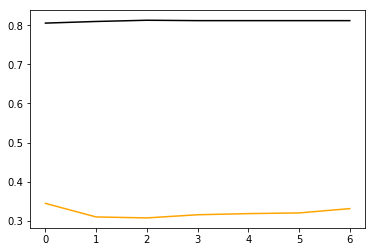

In [116]:
print('Train score : ', [round(x, 4) for x in train_score])
print('Valid score : ', [round(x, 4) for x in valid_score])

plt.plot(train_score, color = 'black')
plt.plot(valid_score, color = 'orange')

plt.show()


### 2) min_samples_leaf : minimum number of samples required to be at a leaf node

In [117]:
min_samples_leaf_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# decreasing min_samples_leaf may result in overfitting

train_score = []
valid_score = []
for min_samples_leaf_val in min_samples_leaf_range :

    rf = RandomForestClassifier(random_state = 1,
                                n_estimators = 25,
                                min_samples_leaf = min_samples_leaf_val)

    rf = rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_train)
    tab = confusion_matrix(y_train, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    train_score.append(f1) 
    
    rf_pred = rf.predict(X_valid)
    tab = confusion_matrix(y_valid, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    valid_score.append(f1) 


Train score :  [0.8127, 0.6452, 0.6042, 0.5872, 0.5723, 0.5253, 0.5304, 0.5159, 0.5174, 0.4984]
Valid score :  [0.2648, 0.3586, 0.3881, 0.3846, 0.3485, 0.315, 0.359, 0.3465, 0.3538, 0.2881]


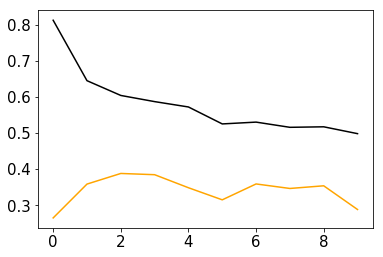

In [52]:
print('Train score : ', [round(x, 4) for x in train_score])
print('Valid score : ', [round(x, 4) for x in valid_score])

plt.plot(train_score, color = 'black')
plt.plot(valid_score, color = 'orange')

plt.show()


### 3) max_depth : maximum depth of the tree

In [118]:
max_depth_range = [20, 25, 30, 35, 40, 45, 50] 
# increasing max_depth may result in overfitting

train_score = []
valid_score = []
for max_depth_val in max_depth_range :
    rf = RandomForestClassifier(random_state = 1,
                                n_estimators = 25,
                                min_samples_leaf = 3,
                                max_depth = max_depth_val)

    rf = rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_train)
    tab = confusion_matrix(y_train, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    train_score.append(f1) 
    
    rf_pred = rf.predict(X_valid)
    tab = confusion_matrix(y_valid, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    valid_score.append(f1) 


Train score :  [0.6353, 0.6313, 0.6433, 0.6512, 0.6512, 0.6512, 0.6512]
Valid score :  [0.3833, 0.4034, 0.3721, 0.3721, 0.3721, 0.3721, 0.3721]


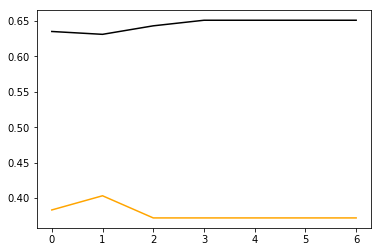

In [119]:
print('Train score : ', [round(x, 4) for x in train_score])
print('Valid score : ', [round(x, 4) for x in valid_score])

plt.plot(train_score, color = 'black')
plt.plot(valid_score, color = 'orange')

plt.show()


### 4) max_features : number of features to consider for each split

In [120]:
max_features_range = [1, 5, 10, 15, 20] 
# increasing max_features may result in overfitting

train_score = []
valid_score = []
for max_features_val in max_features_range :
    rf = RandomForestClassifier(random_state = 1,
                                n_estimators = 25,
                                min_samples_leaf = 3,
                                max_depth = 25,
                                max_features = max_features_val)

    rf = rf.fit(X_train, y_train)
    
    rf_pred = rf.predict(X_train)
    tab = confusion_matrix(y_train, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    train_score.append(f1) 
    
    rf_pred = rf.predict(X_valid)
    tab = confusion_matrix(y_valid, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    valid_score.append(f1) 


Train score :  [0.3, 0.6433, 0.659, 0.6742, 0.6927]
Valid score :  [0.1951, 0.3898, 0.3788, 0.3676, 0.3676]


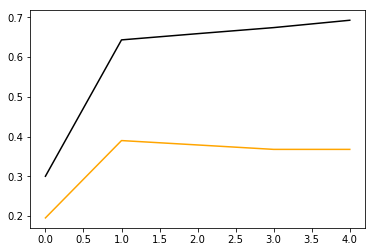

In [121]:
print('Train score : ', [round(x, 4) for x in train_score])
print('Valid score : ', [round(x, 4) for x in valid_score])

plt.plot(train_score, color = 'black')
plt.plot(valid_score, color = 'orange')

plt.show()


### 5) 10-folds cross validation

In [122]:
rf = RandomForestClassifier(random_state = 1)

n_estimators_range = [25, 50] 
min_samples_leaf_range = [3, 4, 5]
max_depth_range = [20, 25, 30] 
max_features_range = [4, 5, 6]

param_grid = [{'n_estimators' : n_estimators_range,
              'max_depth' : max_depth_range,
              'min_samples_leaf' : min_samples_leaf_range,
              'max_features' : max_features_range}]

gs = GridSearchCV(estimator = rf,
                  param_grid = param_grid,
                  cv = 10,
                  scoring = 'f1')

gs = gs.fit(X_train, y_train)
rf = gs.best_estimator_
print(rf)

rf_pred = rf.predict(X_test)

tab = confusion_matrix(y_test, rf_pred)
mc = (tab[0,1] + tab[1,0]) / (tab[0,0] + tab[0,1] + tab[1,0] + tab[1,1])
rec = tab[1,1] / (tab[1,1] + tab[1,0])
pre = tab[1,1] / (tab[1,1] + tab[0,1])
f1 = (2 * rec * pre) / (rec + pre)

print(tab)
print('Misclassification rate : ', round(mc * 100, 2))
print('Recall : ', round(rec * 100, 2))
print('Precision : ', round(pre * 100, 2))
print('f1 : ', round(f1 * 100, 2))



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)


array([[13593,   266],
       [   42,    32]])

In [ ]:
pd.crosstab(rf_pred, columns = 'count')

# 3. 추가 분석

## 1) Under sampling

In [138]:
under_range = [0.2, 0.4, 0.6, 0.8, 1]

train_score = []
valid_score = []
for under_val in under_range :
    zero = train[train['spam'] == 0]
    one = train[train['spam'] == 1]

    np.random.seed(1)
    zero = zero.iloc[np.random.choice(np.shape(zero)[0], round(np.shape(zero)[0] * under_val)), :]

    train_under_samp = pd.concat([one, zero])

    X_train_under_samp = train_under_samp.drop(columns = ['spam'])
    y_train_under_samp = train_under_samp.spam

    rf = RandomForestClassifier(random_state = 1,
                                n_estimators = 200,
                                min_samples_leaf = 3,
                                max_depth = 35,
                                max_features = 6)
    rf = rf.fit(X_train_under_samp, y_train_under_samp)
    rf_pred = rf.predict(X_train_under_samp)
    
    tab = confusion_matrix(y_train_under_samp, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    train_score.append(f1) 
    
    rf_pred = rf.predict(X_valid)
    tab = confusion_matrix(y_valid, rf_pred)
    
    rec = tab[1,1] / (tab[1,1] + tab[1,0])
    pre = tab[1,1] / (tab[1,1] + tab[0,1])
    f1 = (2 * rec * pre) / (rec + pre)
    
    valid_score.append(f1) 


Train score :  [0.6977, 0.6608, 0.6325, 0.6186, 0.6108]
Valid score :  [0.1517, 0.3742, 0.383, 0.3796, 0.3788]


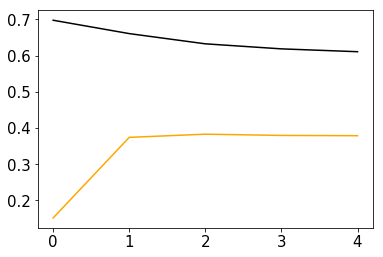

In [60]:
print('Train score : ', [round(x, 4) for x in train_score])
print('Valid score : ', [round(x, 4) for x in valid_score])

plt.plot(train_score, color = 'black')
plt.plot(valid_score, color = 'orange')

plt.show()


In [63]:
np.random.seed(1)
zero = zero.iloc[np.random.choice(np.shape(zero)[0], round(np.shape(zero)[0] * 0.6)), :]

train_under_samp = pd.concat([one, zero])

X_train_under_samp = train_under_samp.drop(columns = ['spam'])
y_train_under_samp = train_under_samp.spam

rf = RandomForestClassifier(random_state = 1,
                                n_estimators = 200,
                                min_samples_leaf = 3,
                                max_depth = 35,
                                max_features = 6)
rf = rf.fit(X_train_under_samp, y_train_under_samp)
rf_pred = rf.predict(X_test)
    
confusion_matrix(y_test, rf_pred)


array([[13359,   500],
       [   40,    34]])

recall은 높아졌지만 precision이 낮아짐

## 2) Importance plot

In [124]:
rf = RandomForestClassifier(random_state = 1,
                            n_estimators = 25,
                            min_samples_leaf = 3,
                            max_depth = 20,
                            max_features = 6)
rf = rf.fit(X_train, y_train)

importance = pd.Series([round(x, 4) for x in rf.feature_importances_], index = X_train.columns)
importance

blog                      0.0002
cover                     0.0026
employee_count            0.0014
exit_type                 0.0105
facebook                  0.0020
found_date                0.0070
github                    0.0000
googleplus                0.0000
instagram                 0.0030
kakao_story               0.0000
logo                      0.0053
phone                     0.0016
pinterest                 0.0000
twitter                   0.0005
view_count                0.0865
yellow_id                 0.0000
youtube                   0.0000
num_nan                   0.0200
description_spam          0.0535
description_ham           0.0253
homepage_n                0.0111
name_spam                 0.1861
name_ham                  0.0417
overview_n                0.0054
overview_spam             0.0072
overview_ham              0.0114
pm_binary                 0.1728
can_military_service_0    0.0000
can_military_service_1    0.0000
can_military_service_2    0.0000
descriptio

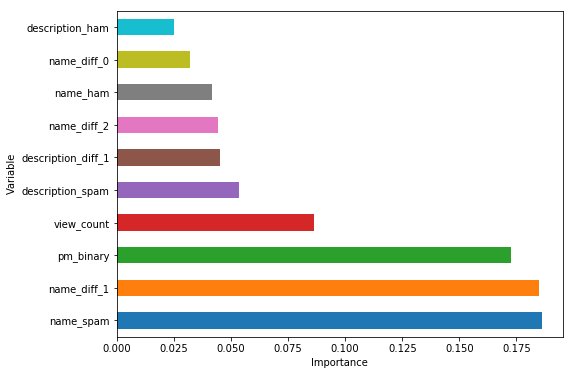

In [125]:
plt.figure(figsize=(8,6))

importance.nlargest(10).plot(kind = 'barh')
plt.xlabel('Importance')
plt.ylabel('Variable')

plt.rc('font', size = 15)

plt.show()

## 3) Fitting random forest again

In [129]:
rf_b = RandomForestClassifier(random_state = 1,
                            n_estimators = 25,
                            min_samples_leaf = 3,
                            max_depth = 20,
                            max_features = 6)
rf_b = rf_b.fit(X_train, y_train)

rf_pred = rf_b.predict(X_train)

one_idx = train[rf_pred == 1].index.tolist() 
X_train_one = X_train.loc[one_idx, :]
y_train_one = y_train[one_idx]

rf = RandomForestClassifier(random_state = 1)

param_grid = [{'n_estimators' : [25, 50],
              'max_depth' : [10, 15, 20, 25],
              'min_samples_leaf' : [1, 2, 3, 4, 5],
              'max_features' : [5, 10, 15, 20]}]
gscv = GridSearchCV(estimator = rf,
                  param_grid = param_grid,
                  cv = 10,
                  scoring = 'recall')

gs = gscv.fit(X_train_one, y_train_one)
rf_one = gs.best_estimator_

zero_idx = train[rf_pred == 0].index.tolist() 
X_train_zero = X_train.loc[zero_idx, :]
y_train_zero = y_train[zero_idx]

gs = gscv.fit(X_train_zero, y_train_zero)
rf_zero = gs.best_estimator_


In [130]:
rf_pred = rf_b.predict(X_test)

one_idx = test[rf_pred == 1].index.tolist() # spam이라고 예측한 test의 index
X_test_one = X_test.loc[one_idx, :]
y_test_one = y_test[one_idx]

one_pred = rf_one.predict(X_test_one)

confusion_matrix(y_test_one, one_pred)


array([[  0, 266],
       [  0,  32]])

In [131]:
zero_idx = test[rf_pred == 0].index.tolist() # spam이라고 예측한 test의 index
X_test_zero = X_test.loc[zero_idx, :]
y_test_zero = y_test[zero_idx]

zero_pred = rf_zero.predict(X_test_zero)

confusion_matrix(y_test_zero, zero_pred)


array([[11446,  2147],
       [    8,    34]])

In [132]:
test['f_pred'] = 0

test.f_pred[one_idx] = one_pred
test.f_pred[zero_idx] = zero_pred

In [133]:
confusion_matrix(y_test, test.f_pred)

array([[11446,  2413],
       [    8,    66]])

recall은 높아졌지만 precision이 낮아짐

# 4. Save result

test 데이터에서 스팸인데 스팸이 아니라고 분류한 데이터

In [134]:
w_idx = test[np.logical_and(rf_b.predict(X_test) == 0, y_test == 1)].index.tolist()
spam_no_spam = o_test.iloc[w_idx, :]
spam_no_spam2 = test.loc[w_idx, :]

print(spam_no_spam.head())

spam_no_spam.to_csv('spam_no_spam.csv', encoding = 'utf-8', index = False)
spam_no_spam2.to_csv('spam_no_spam2.csv', encoding = 'utf-8', index = False)


      blog                                      cover  \
21000  NaN                                        NaN   
12559  NaN                                        NaN   
14285  NaN  company/17308/na-108_cover_1462369293.jpg   
23899  NaN                                        NaN   
1456   NaN                                        NaN   

                                             description  employee_count  \
21000                                                NaN             NaN   
12559                                                NaN             NaN   
14285                                        3년내 Exit 목표             NaN   
23899                                                NaN             NaN   
1456   다양한 색깔의 사람들이 모여 문제를 가진 고객을 찾고 세상의 문제를 함께 고민하고 ...             NaN   

       exit_type facebook found_date github googleplus homepage  \
21000        NaN      NaN        NaN    NaN        NaN      NaN   
12559        NaN      NaN        NaN    NaN        NaN      NaN   

test 데이터에서 스팸이 아닌데 스팸이라고 분류한 데이터

In [136]:
w_idx = test[np.logical_and(rf_b.predict(X_test) == 1, y_test == 0)].index.tolist()
no_spam_spam = o_test.iloc[w_idx, :]
print(no_spam_spam.head())

no_spam_spam.to_csv('no_spam_spam.csv', encoding = 'utf-8', index = False)


      blog cover    description  employee_count  exit_type facebook  \
15197  NaN   NaN            NaN             NaN        NaN      NaN   
10500  NaN   NaN  고객에게 가치를 전달하는             NaN        NaN      NaN   
9836   NaN   NaN            NaN             NaN        NaN      NaN   
16844  NaN   NaN            NaN             NaN        NaN      NaN   
25498  NaN   NaN            NaN             NaN        NaN      NaN   

       found_date github googleplus homepage           ...            \
15197         NaN    NaN        NaN      NaN           ...             
10500  2017-09-06    NaN        NaN      NaN           ...             
9836          NaN    NaN        NaN      NaN           ...             
16844         NaN    NaN        NaN      NaN           ...             
25498         NaN    NaN        NaN      NaN           ...             

      pinterest twitter view_count yellow_id youtube spam   num_nan  \
15197       NaN     NaN   0.000596       NaN     NaN    0  0.933333  

In [137]:
prediction = pd.DataFrame({'Index' : test.index,
                           'Actual' : y_test,
                           'Predict' : rf_b.predict(X_test)})
prediction.to_csv('prediction.csv', encoding = 'utf-8', index = False)
